## Libraries

In [1]:
import os
import time
import requests

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from model_analysis import get_report_model,get_test_train_data
from models_analysis.raw_scaled_data import get_raw_scaled_data
from models_analysis.classic_models_evaluation import get_models_bayesian_to_evaluate

from models_analysis.bo_models_evaluation import suggest_hyperparameters, objective
import optuna
from sklearn.preprocessing import LabelEncoder

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [2]:
#Webhook of my channel. Click on edit channel --> Webhooks --> Creates webhook
mUrl = "https://discord.com/api/webhooks/1237653552495595550/uvRM3kO8U-hCUV-qw8iQdu-SVHGpofRuLwWAg9zqDLJ4Gr9pA0_EL0QUgxPuigRSoKvw"

n_cpu = os.cpu_count()

SIZE_SAMPLE = 80

print("Number of CPUs in the system:", n_cpu)

Number of CPUs in the system: 16


In [3]:
def print_d(url, message):
    response = requests.post(url, json={"content": message})

Load data

In [4]:
dataset = pd.read_pickle('./model_data/patterns_dataset.pkl')

Results final table

In [5]:
results = [] ## Acumulate scores for final table

Labels

In [6]:
le = LabelEncoder()
labels = le.fit_transform(dataset['pattern'])
y = labels

In [7]:
def save_model_results(result, model_name, data_type, params, results):
    result = {"name":model_name, "data":data_type, "acc":result[0],
          "precision":result[1], "recall":result[2], "f1":result[3], "roc":result[4],"time":result[5],
          "params":params}
    results.append(result)

# Bayesian Optimization Values

In [8]:
time_series = get_raw_scaled_data(dataset)
models_bayesian = get_models_bayesian_to_evaluate()

In [ ]:
print(f"****** Bayesian Opt without patch ******")
for models_bo in models_bayesian:
    print(f"****** model: {models_bo.name} ******")
    print_d(mUrl,f"****** model: {models_bo.name} ******")
    for x_data in time_series:
        start = time.time()
        print(f"****** data: {x_data.name} ******")
        print_d(mUrl,f"****** data: {x_data.name} ******")
        np_array = np.array(x_data.data)
        scores_arr=[]
        top_accuracy = 0
        top_params = None
        # Create a study object and specify the direction of optimization
        for i in range(10):
            study = optuna.create_study(direction='maximize')
            study.optimize(lambda trial: objective(trial, models_bo.model, models_bo.params, np_array, y), n_trials=100)
        
            # Print the best hyperparameters
            print("Best hyperparameters: ", study.best_params)
            print("Best cross-validation accuracy: ", study.best_value)
    

            
            # Retrieve and print metrics for the best trial
            best_trial = study.best_trial
            if best_trial.user_attrs["accuracy"] >= top_accuracy:
                top_accuracy = best_trial.user_attrs["accuracy"]
                top_params = study.best_params
            
            print("Best trial metrics:")
            print("  Accuracy: ", best_trial.user_attrs["accuracy"])
            print("  Precision (macro): ", best_trial.user_attrs["precision_macro"])
            print("  Recall (macro): ", best_trial.user_attrs["recall_macro"])
            print("  F1 Score (macro): ", best_trial.user_attrs["f1_macro"])
            print("  ROC AUC (macro): ", best_trial.user_attrs["roc_auc_ovr_macro"])
            print(best_trial.user_attrs)
            df_scores = pd.DataFrame(best_trial.user_attrs, index=[0])
            scores_arr.append(df_scores)
        
        total_seconds = time.time() - start
        
        concat_result = pd.concat(scores_arr)
        accuracy = concat_result['accuracy'].mean()
        precision = concat_result['precision_macro'].mean()
        recall = concat_result['recall_macro'].mean()
        f1 = concat_result['f1_macro'].mean()
        roc = concat_result['roc_auc_ovr_macro'].mean()
        print(f"acc {accuracy}, prec {precision}, recall {recall}, f1 {f1}, roc {roc}")
        print_d(mUrl, f"It took: {total_seconds} seconds")
        print_d(mUrl,f"acc {accuracy}, prec {precision}, recall {recall}, f1 {f1}, roc {roc}")
        result = [accuracy, precision, recall, f1, roc, total_seconds]
    
        save_model_results(result, models_bo.name, x_data.name, top_params, results)

****** Bayesian Opt without patch ******
****** model: KNN ******
****** data: Slope ******


[I 2024-06-03 18:04:36,642] A new study created in memory with name: no-name-135b0fd4-83ce-47ae-8805-a50817eb5461
[I 2024-06-03 18:04:36,703] Trial 0 finished with value: 0.40437500000000004 and parameters: {'n_neighbors': 7, 'weights': 'distance', 'p': 1}. Best is trial 0 with value: 0.40437500000000004.
[I 2024-06-03 18:04:36,762] Trial 1 finished with value: 0.36124999999999996 and parameters: {'n_neighbors': 9, 'weights': 'uniform', 'p': 1}. Best is trial 0 with value: 0.40437500000000004.
/home/danielramosrivera/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/danielramosrivera/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set 

Best hyperparameters:  {'n_neighbors': 2, 'weights': 'distance', 'p': 1}
Best cross-validation accuracy:  0.5349999999999999
Best trial metrics:
  Accuracy:  0.5349999999999999
  Precision (macro):  0.5344771996283776
  Recall (macro):  0.5349999999999999
  F1 Score (macro):  0.49686629049450454
  ROC AUC (macro):  0.7104908854166666
{'accuracy': 0.5349999999999999, 'precision_macro': 0.5344771996283776, 'recall_macro': 0.5349999999999999, 'f1_macro': 0.49686629049450454, 'roc_auc_ovr_macro': 0.7104908854166666}


[I 2024-06-03 18:04:42,584] Trial 3 finished with value: 0.303125 and parameters: {'n_neighbors': 21, 'weights': 'distance', 'p': 1}. Best is trial 1 with value: 0.5349999999999999.
[I 2024-06-03 18:04:42,639] Trial 4 finished with value: 0.5349999999999999 and parameters: {'n_neighbors': 1, 'weights': 'uniform', 'p': 1}. Best is trial 1 with value: 0.5349999999999999.
[I 2024-06-03 18:04:42,706] Trial 5 finished with value: 0.309375 and parameters: {'n_neighbors': 16, 'weights': 'uniform', 'p': 1}. Best is trial 1 with value: 0.5349999999999999.
[I 2024-06-03 18:04:42,750] Trial 6 finished with value: 0.396875 and parameters: {'n_neighbors': 10, 'weights': 'uniform', 'p': 2}. Best is trial 1 with value: 0.5349999999999999.
[I 2024-06-03 18:04:42,786] Trial 7 finished with value: 0.496875 and parameters: {'n_neighbors': 1, 'weights': 'distance', 'p': 2}. Best is trial 1 with value: 0.5349999999999999.
[I 2024-06-03 18:04:42,845] Trial 8 finished with value: 0.33374999999999994 and para

Best hyperparameters:  {'n_neighbors': 2, 'weights': 'distance', 'p': 1}
Best cross-validation accuracy:  0.5349999999999999
Best trial metrics:
  Accuracy:  0.5349999999999999
  Precision (macro):  0.5344771996283776
  Recall (macro):  0.5349999999999999
  F1 Score (macro):  0.49686629049450454
  ROC AUC (macro):  0.7104908854166666
{'accuracy': 0.5349999999999999, 'precision_macro': 0.5344771996283776, 'recall_macro': 0.5349999999999999, 'f1_macro': 0.49686629049450454, 'roc_auc_ovr_macro': 0.7104908854166666}


[I 2024-06-03 18:04:48,578] Trial 3 finished with value: 0.37125 and parameters: {'n_neighbors': 15, 'weights': 'distance', 'p': 2}. Best is trial 1 with value: 0.478125.
[I 2024-06-03 18:04:48,647] Trial 4 finished with value: 0.289375 and parameters: {'n_neighbors': 23, 'weights': 'uniform', 'p': 1}. Best is trial 1 with value: 0.478125.
[I 2024-06-03 18:04:48,703] Trial 5 finished with value: 0.323125 and parameters: {'n_neighbors': 30, 'weights': 'uniform', 'p': 2}. Best is trial 1 with value: 0.478125.
[I 2024-06-03 18:04:48,755] Trial 6 finished with value: 0.35 and parameters: {'n_neighbors': 21, 'weights': 'distance', 'p': 2}. Best is trial 1 with value: 0.478125.
/home/danielramosrivera/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} 

Best hyperparameters:  {'n_neighbors': 1, 'weights': 'distance', 'p': 1}
Best cross-validation accuracy:  0.5349999999999999
Best trial metrics:
  Accuracy:  0.5349999999999999
  Precision (macro):  0.5344771996283776
  Recall (macro):  0.5349999999999999
  F1 Score (macro):  0.49686629049450454
  ROC AUC (macro):  0.6900000000000001
{'accuracy': 0.5349999999999999, 'precision_macro': 0.5344771996283776, 'recall_macro': 0.5349999999999999, 'f1_macro': 0.49686629049450454, 'roc_auc_ovr_macro': 0.6900000000000001}


[I 2024-06-03 18:04:54,702] Trial 3 finished with value: 0.41937500000000005 and parameters: {'n_neighbors': 6, 'weights': 'uniform', 'p': 2}. Best is trial 3 with value: 0.41937500000000005.
[I 2024-06-03 18:04:54,741] Trial 4 finished with value: 0.42437499999999995 and parameters: {'n_neighbors': 7, 'weights': 'distance', 'p': 2}. Best is trial 4 with value: 0.42437499999999995.
[I 2024-06-03 18:04:54,817] Trial 5 finished with value: 0.284375 and parameters: {'n_neighbors': 27, 'weights': 'distance', 'p': 1}. Best is trial 4 with value: 0.42437499999999995.
[I 2024-06-03 18:04:54,858] Trial 6 finished with value: 0.43562500000000004 and parameters: {'n_neighbors': 5, 'weights': 'distance', 'p': 2}. Best is trial 6 with value: 0.43562500000000004.
[I 2024-06-03 18:04:54,913] Trial 7 finished with value: 0.37125 and parameters: {'n_neighbors': 15, 'weights': 'distance', 'p': 2}. Best is trial 6 with value: 0.43562500000000004.
[I 2024-06-03 18:04:54,983] Trial 8 finished with value: 

Best hyperparameters:  {'n_neighbors': 2, 'weights': 'distance', 'p': 1}
Best cross-validation accuracy:  0.5349999999999999
Best trial metrics:
  Accuracy:  0.5349999999999999
  Precision (macro):  0.5344771996283776
  Recall (macro):  0.5349999999999999
  F1 Score (macro):  0.49686629049450454
  ROC AUC (macro):  0.7104908854166666
{'accuracy': 0.5349999999999999, 'precision_macro': 0.5344771996283776, 'recall_macro': 0.5349999999999999, 'f1_macro': 0.49686629049450454, 'roc_auc_ovr_macro': 0.7104908854166666}


[I 2024-06-03 18:05:00,458] Trial 3 finished with value: 0.418125 and parameters: {'n_neighbors': 5, 'weights': 'uniform', 'p': 1}. Best is trial 2 with value: 0.478125.
[I 2024-06-03 18:05:00,521] Trial 4 finished with value: 0.31875 and parameters: {'n_neighbors': 14, 'weights': 'uniform', 'p': 1}. Best is trial 2 with value: 0.478125.
[I 2024-06-03 18:05:00,572] Trial 5 finished with value: 0.34750000000000003 and parameters: {'n_neighbors': 22, 'weights': 'distance', 'p': 2}. Best is trial 2 with value: 0.478125.
[I 2024-06-03 18:05:00,616] Trial 6 finished with value: 0.4 and parameters: {'n_neighbors': 11, 'weights': 'distance', 'p': 2}. Best is trial 2 with value: 0.478125.
[I 2024-06-03 18:05:00,669] Trial 7 finished with value: 0.34625 and parameters: {'n_neighbors': 24, 'weights': 'distance', 'p': 2}. Best is trial 2 with value: 0.478125.
[I 2024-06-03 18:05:00,732] Trial 8 finished with value: 0.31875 and parameters: {'n_neighbors': 14, 'weights': 'uniform', 'p': 1}. Best is

Best hyperparameters:  {'n_neighbors': 1, 'weights': 'distance', 'p': 1}
Best cross-validation accuracy:  0.5349999999999999
Best trial metrics:
  Accuracy:  0.5349999999999999
  Precision (macro):  0.5344771996283776
  Recall (macro):  0.5349999999999999
  F1 Score (macro):  0.49686629049450454
  ROC AUC (macro):  0.6900000000000001
{'accuracy': 0.5349999999999999, 'precision_macro': 0.5344771996283776, 'recall_macro': 0.5349999999999999, 'f1_macro': 0.49686629049450454, 'roc_auc_ovr_macro': 0.6900000000000001}


[I 2024-06-03 18:05:06,774] Trial 3 finished with value: 0.43562500000000004 and parameters: {'n_neighbors': 5, 'weights': 'distance', 'p': 2}. Best is trial 3 with value: 0.43562500000000004.
[I 2024-06-03 18:05:06,831] Trial 4 finished with value: 0.36 and parameters: {'n_neighbors': 17, 'weights': 'distance', 'p': 2}. Best is trial 3 with value: 0.43562500000000004.
[I 2024-06-03 18:05:06,882] Trial 5 finished with value: 0.34812499999999996 and parameters: {'n_neighbors': 20, 'weights': 'uniform', 'p': 2}. Best is trial 3 with value: 0.43562500000000004.
/home/danielramosrivera/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/danielramosrivera/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:151

Best hyperparameters:  {'n_neighbors': 1, 'weights': 'distance', 'p': 2}
Best cross-validation accuracy:  0.496875
Best trial metrics:
  Accuracy:  0.496875
  Precision (macro):  0.46694742272229506
  Recall (macro):  0.496875
  F1 Score (macro):  0.46976316064783086
  ROC AUC (macro):  0.6645833333333333
{'accuracy': 0.496875, 'precision_macro': 0.46694742272229506, 'recall_macro': 0.496875, 'f1_macro': 0.46976316064783086, 'roc_auc_ovr_macro': 0.6645833333333333}


[I 2024-06-03 18:05:11,576] Trial 3 finished with value: 0.343125 and parameters: {'n_neighbors': 24, 'weights': 'uniform', 'p': 2}. Best is trial 0 with value: 0.4125.
[I 2024-06-03 18:05:11,617] Trial 4 finished with value: 0.43562500000000004 and parameters: {'n_neighbors': 5, 'weights': 'distance', 'p': 2}. Best is trial 4 with value: 0.43562500000000004.
[I 2024-06-03 18:05:11,659] Trial 5 finished with value: 0.415625 and parameters: {'n_neighbors': 7, 'weights': 'uniform', 'p': 2}. Best is trial 4 with value: 0.43562500000000004.
[I 2024-06-03 18:05:11,721] Trial 6 finished with value: 0.38937499999999997 and parameters: {'n_neighbors': 7, 'weights': 'uniform', 'p': 1}. Best is trial 4 with value: 0.43562500000000004.
[I 2024-06-03 18:05:11,793] Trial 7 finished with value: 0.308125 and parameters: {'n_neighbors': 20, 'weights': 'distance', 'p': 1}. Best is trial 4 with value: 0.43562500000000004.
[I 2024-06-03 18:05:11,843] Trial 8 finished with value: 0.355625 and parameters: 

Best hyperparameters:  {'n_neighbors': 2, 'weights': 'distance', 'p': 1}
Best cross-validation accuracy:  0.5349999999999999
Best trial metrics:
  Accuracy:  0.5349999999999999
  Precision (macro):  0.5344771996283776
  Recall (macro):  0.5349999999999999
  F1 Score (macro):  0.49686629049450454
  ROC AUC (macro):  0.7104908854166666
{'accuracy': 0.5349999999999999, 'precision_macro': 0.5344771996283776, 'recall_macro': 0.5349999999999999, 'f1_macro': 0.49686629049450454, 'roc_auc_ovr_macro': 0.7104908854166666}


[I 2024-06-03 18:05:17,049] Trial 4 finished with value: 0.35625 and parameters: {'n_neighbors': 19, 'weights': 'distance', 'p': 2}. Best is trial 3 with value: 0.496875.
[I 2024-06-03 18:05:17,103] Trial 5 finished with value: 0.323125 and parameters: {'n_neighbors': 30, 'weights': 'uniform', 'p': 2}. Best is trial 3 with value: 0.496875.
[I 2024-06-03 18:05:17,146] Trial 6 finished with value: 0.403125 and parameters: {'n_neighbors': 10, 'weights': 'distance', 'p': 2}. Best is trial 3 with value: 0.496875.
[I 2024-06-03 18:05:17,217] Trial 7 finished with value: 0.296875 and parameters: {'n_neighbors': 23, 'weights': 'distance', 'p': 1}. Best is trial 3 with value: 0.496875.
/home/danielramosrivera/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitaliz

Best hyperparameters:  {'n_neighbors': 1, 'weights': 'distance', 'p': 1}
Best cross-validation accuracy:  0.5349999999999999
Best trial metrics:
  Accuracy:  0.5349999999999999
  Precision (macro):  0.5344771996283776
  Recall (macro):  0.5349999999999999
  F1 Score (macro):  0.49686629049450454
  ROC AUC (macro):  0.6900000000000001
{'accuracy': 0.5349999999999999, 'precision_macro': 0.5344771996283776, 'recall_macro': 0.5349999999999999, 'f1_macro': 0.49686629049450454, 'roc_auc_ovr_macro': 0.6900000000000001}


[I 2024-06-03 18:05:22,784] Trial 3 finished with value: 0.403125 and parameters: {'n_neighbors': 10, 'weights': 'distance', 'p': 2}. Best is trial 3 with value: 0.403125.
/home/danielramosrivera/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/danielramosrivera/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
[I 2024-06-03 18:05:22,856] Trial 4 finished with value: 0.281875 and parameters: {'n_neighbors': 25, 'weights': 'uniform', 'p': 1}. Best is trial 3 with 

Best hyperparameters:  {'n_neighbors': 2, 'weights': 'distance', 'p': 1}
Best cross-validation accuracy:  0.5349999999999999
Best trial metrics:
  Accuracy:  0.5349999999999999
  Precision (macro):  0.5344771996283776
  Recall (macro):  0.5349999999999999
  F1 Score (macro):  0.49686629049450454
  ROC AUC (macro):  0.7104908854166666
{'accuracy': 0.5349999999999999, 'precision_macro': 0.5344771996283776, 'recall_macro': 0.5349999999999999, 'f1_macro': 0.49686629049450454, 'roc_auc_ovr_macro': 0.7104908854166666}


[I 2024-06-03 18:05:27,789] Trial 3 finished with value: 0.339375 and parameters: {'n_neighbors': 23, 'weights': 'uniform', 'p': 2}. Best is trial 2 with value: 0.43562500000000004.
[I 2024-06-03 18:05:27,828] Trial 4 finished with value: 0.42562500000000003 and parameters: {'n_neighbors': 5, 'weights': 'uniform', 'p': 2}. Best is trial 2 with value: 0.43562500000000004.
[I 2024-06-03 18:05:27,886] Trial 5 finished with value: 0.32625000000000004 and parameters: {'n_neighbors': 12, 'weights': 'uniform', 'p': 1}. Best is trial 2 with value: 0.43562500000000004.
[I 2024-06-03 18:05:27,938] Trial 6 finished with value: 0.339375 and parameters: {'n_neighbors': 23, 'weights': 'uniform', 'p': 2}. Best is trial 2 with value: 0.43562500000000004.
[I 2024-06-03 18:05:27,982] Trial 7 finished with value: 0.41937500000000005 and parameters: {'n_neighbors': 6, 'weights': 'uniform', 'p': 2}. Best is trial 2 with value: 0.43562500000000004.
[I 2024-06-03 18:05:28,022] Trial 8 finished with value: 0.

Best hyperparameters:  {'n_neighbors': 1, 'weights': 'distance', 'p': 1}
Best cross-validation accuracy:  0.5349999999999999
Best trial metrics:
  Accuracy:  0.5349999999999999
  Precision (macro):  0.5344771996283776
  Recall (macro):  0.5349999999999999
  F1 Score (macro):  0.49686629049450454
  ROC AUC (macro):  0.6900000000000001
{'accuracy': 0.5349999999999999, 'precision_macro': 0.5344771996283776, 'recall_macro': 0.5349999999999999, 'f1_macro': 0.49686629049450454, 'roc_auc_ovr_macro': 0.6900000000000001}
acc 0.5311874999999999, prec 0.5277242219377694, recall 0.5311874999999999, f1 0.4941559775098372, roc 0.6977037760416667
****** data: Path_eff ******


[I 2024-06-03 18:05:34,573] A new study created in memory with name: no-name-3b86975d-27e7-46c5-9cc8-f7a8c64d127d
[I 2024-06-03 18:05:34,653] Trial 0 finished with value: 0.8393750000000001 and parameters: {'n_neighbors': 29, 'weights': 'uniform', 'p': 1}. Best is trial 0 with value: 0.8393750000000001.
[I 2024-06-03 18:05:34,690] Trial 1 finished with value: 0.8731249999999999 and parameters: {'n_neighbors': 3, 'weights': 'distance', 'p': 2}. Best is trial 1 with value: 0.8731249999999999.
[I 2024-06-03 18:05:34,753] Trial 2 finished with value: 0.8543749999999999 and parameters: {'n_neighbors': 25, 'weights': 'distance', 'p': 2}. Best is trial 1 with value: 0.8731249999999999.
[I 2024-06-03 18:05:34,812] Trial 3 finished with value: 0.85375 and parameters: {'n_neighbors': 23, 'weights': 'distance', 'p': 2}. Best is trial 1 with value: 0.8731249999999999.
[I 2024-06-03 18:05:34,870] Trial 4 finished with value: 0.8474999999999999 and parameters: {'n_neighbors': 25, 'weights': 'uniform

Best hyperparameters:  {'n_neighbors': 4, 'weights': 'distance', 'p': 2}
Best cross-validation accuracy:  0.8762500000000001
Best trial metrics:
  Accuracy:  0.8762500000000001
  Precision (macro):  0.8850292739138894
  Recall (macro):  0.87625
  F1 Score (macro):  0.8753839410325425
  ROC AUC (macro):  0.9612395833333334
{'accuracy': 0.8762500000000001, 'precision_macro': 0.8850292739138894, 'recall_macro': 0.87625, 'f1_macro': 0.8753839410325425, 'roc_auc_ovr_macro': 0.9612395833333334}


[I 2024-06-03 18:05:39,766] Trial 3 finished with value: 0.853125 and parameters: {'n_neighbors': 20, 'weights': 'uniform', 'p': 2}. Best is trial 1 with value: 0.859375.
[I 2024-06-03 18:05:39,847] Trial 4 finished with value: 0.849375 and parameters: {'n_neighbors': 27, 'weights': 'distance', 'p': 1}. Best is trial 1 with value: 0.859375.
[I 2024-06-03 18:05:39,903] Trial 5 finished with value: 0.865 and parameters: {'n_neighbors': 7, 'weights': 'uniform', 'p': 1}. Best is trial 5 with value: 0.865.
[I 2024-06-03 18:05:39,947] Trial 6 finished with value: 0.8675 and parameters: {'n_neighbors': 10, 'weights': 'distance', 'p': 2}. Best is trial 6 with value: 0.8675.
[I 2024-06-03 18:05:40,032] Trial 7 finished with value: 0.8487499999999999 and parameters: {'n_neighbors': 28, 'weights': 'distance', 'p': 1}. Best is trial 6 with value: 0.8675.
[I 2024-06-03 18:05:40,099] Trial 8 finished with value: 0.859375 and parameters: {'n_neighbors': 13, 'weights': 'distance', 'p': 1}. Best is tri

Best hyperparameters:  {'n_neighbors': 1, 'weights': 'distance', 'p': 2}
Best cross-validation accuracy:  0.8762500000000001
Best trial metrics:
  Accuracy:  0.8762500000000001
  Precision (macro):  0.8819819807082135
  Recall (macro):  0.87625
  F1 Score (macro):  0.875731023336584
  ROC AUC (macro):  0.9175000000000001
{'accuracy': 0.8762500000000001, 'precision_macro': 0.8819819807082135, 'recall_macro': 0.87625, 'f1_macro': 0.875731023336584, 'roc_auc_ovr_macro': 0.9175000000000001}


[I 2024-06-03 18:05:44,477] Trial 3 finished with value: 0.86 and parameters: {'n_neighbors': 10, 'weights': 'uniform', 'p': 1}. Best is trial 1 with value: 0.86875.
[I 2024-06-03 18:05:44,529] Trial 4 finished with value: 0.86875 and parameters: {'n_neighbors': 3, 'weights': 'distance', 'p': 1}. Best is trial 1 with value: 0.86875.
[I 2024-06-03 18:05:44,611] Trial 5 finished with value: 0.85 and parameters: {'n_neighbors': 30, 'weights': 'distance', 'p': 1}. Best is trial 1 with value: 0.86875.
[I 2024-06-03 18:05:44,677] Trial 6 finished with value: 0.8543749999999999 and parameters: {'n_neighbors': 25, 'weights': 'distance', 'p': 2}. Best is trial 1 with value: 0.86875.
[I 2024-06-03 18:05:44,714] Trial 7 finished with value: 0.8674999999999999 and parameters: {'n_neighbors': 2, 'weights': 'uniform', 'p': 2}. Best is trial 1 with value: 0.86875.
[I 2024-06-03 18:05:44,763] Trial 8 finished with value: 0.8724999999999999 and parameters: {'n_neighbors': 2, 'weights': 'distance', 'p':

Best hyperparameters:  {'n_neighbors': 4, 'weights': 'distance', 'p': 2}
Best cross-validation accuracy:  0.8762500000000001
Best trial metrics:
  Accuracy:  0.8762500000000001
  Precision (macro):  0.8850292739138894
  Recall (macro):  0.87625
  F1 Score (macro):  0.8753839410325425
  ROC AUC (macro):  0.9612395833333334
{'accuracy': 0.8762500000000001, 'precision_macro': 0.8850292739138894, 'recall_macro': 0.87625, 'f1_macro': 0.8753839410325425, 'roc_auc_ovr_macro': 0.9612395833333334}


[I 2024-06-03 18:05:49,203] Trial 3 finished with value: 0.850625 and parameters: {'n_neighbors': 29, 'weights': 'distance', 'p': 1}. Best is trial 1 with value: 0.8731249999999999.
[I 2024-06-03 18:05:49,263] Trial 4 finished with value: 0.869375 and parameters: {'n_neighbors': 8, 'weights': 'distance', 'p': 1}. Best is trial 1 with value: 0.8731249999999999.
[I 2024-06-03 18:05:49,339] Trial 5 finished with value: 0.8387500000000001 and parameters: {'n_neighbors': 27, 'weights': 'uniform', 'p': 1}. Best is trial 1 with value: 0.8731249999999999.
[I 2024-06-03 18:05:49,396] Trial 6 finished with value: 0.8568749999999999 and parameters: {'n_neighbors': 22, 'weights': 'distance', 'p': 2}. Best is trial 1 with value: 0.8731249999999999.
[I 2024-06-03 18:05:49,444] Trial 7 finished with value: 0.8724999999999999 and parameters: {'n_neighbors': 1, 'weights': 'distance', 'p': 1}. Best is trial 1 with value: 0.8731249999999999.
[I 2024-06-03 18:05:49,483] Trial 8 finished with value: 0.8756

Best hyperparameters:  {'n_neighbors': 1, 'weights': 'distance', 'p': 2}
Best cross-validation accuracy:  0.8762500000000001
Best trial metrics:
  Accuracy:  0.8762500000000001
  Precision (macro):  0.8819819807082135
  Recall (macro):  0.87625
  F1 Score (macro):  0.875731023336584
  ROC AUC (macro):  0.9175000000000001
{'accuracy': 0.8762500000000001, 'precision_macro': 0.8819819807082135, 'recall_macro': 0.87625, 'f1_macro': 0.875731023336584, 'roc_auc_ovr_macro': 0.9175000000000001}


[I 2024-06-03 18:05:53,911] Trial 3 finished with value: 0.8462500000000001 and parameters: {'n_neighbors': 29, 'weights': 'uniform', 'p': 2}. Best is trial 0 with value: 0.8712500000000001.
[I 2024-06-03 18:05:53,971] Trial 4 finished with value: 0.844375 and parameters: {'n_neighbors': 27, 'weights': 'uniform', 'p': 2}. Best is trial 0 with value: 0.8712500000000001.
[I 2024-06-03 18:05:54,041] Trial 5 finished with value: 0.8481250000000001 and parameters: {'n_neighbors': 21, 'weights': 'uniform', 'p': 1}. Best is trial 0 with value: 0.8712500000000001.
[I 2024-06-03 18:05:54,113] Trial 6 finished with value: 0.8568749999999999 and parameters: {'n_neighbors': 17, 'weights': 'distance', 'p': 1}. Best is trial 0 with value: 0.8712500000000001.
[I 2024-06-03 18:05:54,173] Trial 7 finished with value: 0.865 and parameters: {'n_neighbors': 8, 'weights': 'uniform', 'p': 1}. Best is trial 0 with value: 0.8712500000000001.
[I 2024-06-03 18:05:54,233] Trial 8 finished with value: 0.854374999

Best hyperparameters:  {'n_neighbors': 4, 'weights': 'distance', 'p': 2}
Best cross-validation accuracy:  0.8762500000000001
Best trial metrics:
  Accuracy:  0.8762500000000001
  Precision (macro):  0.8850292739138894
  Recall (macro):  0.87625
  F1 Score (macro):  0.8753839410325425
  ROC AUC (macro):  0.9612395833333334
{'accuracy': 0.8762500000000001, 'precision_macro': 0.8850292739138894, 'recall_macro': 0.87625, 'f1_macro': 0.8753839410325425, 'roc_auc_ovr_macro': 0.9612395833333334}


[I 2024-06-03 18:05:58,983] Trial 2 finished with value: 0.8487500000000001 and parameters: {'n_neighbors': 26, 'weights': 'distance', 'p': 1}. Best is trial 1 with value: 0.8550000000000001.
[I 2024-06-03 18:05:59,043] Trial 3 finished with value: 0.8543749999999999 and parameters: {'n_neighbors': 25, 'weights': 'distance', 'p': 2}. Best is trial 1 with value: 0.8550000000000001.
[I 2024-06-03 18:05:59,094] Trial 4 finished with value: 0.8724999999999999 and parameters: {'n_neighbors': 1, 'weights': 'uniform', 'p': 1}. Best is trial 4 with value: 0.8724999999999999.
[I 2024-06-03 18:05:59,134] Trial 5 finished with value: 0.8731249999999999 and parameters: {'n_neighbors': 4, 'weights': 'uniform', 'p': 2}. Best is trial 5 with value: 0.8731249999999999.
[I 2024-06-03 18:05:59,185] Trial 6 finished with value: 0.853125 and parameters: {'n_neighbors': 20, 'weights': 'uniform', 'p': 2}. Best is trial 5 with value: 0.8731249999999999.
[I 2024-06-03 18:05:59,237] Trial 7 finished with value

Best hyperparameters:  {'n_neighbors': 1, 'weights': 'uniform', 'p': 2}
Best cross-validation accuracy:  0.8762500000000001
Best trial metrics:
  Accuracy:  0.8762500000000001
  Precision (macro):  0.8819819807082135
  Recall (macro):  0.87625
  F1 Score (macro):  0.875731023336584
  ROC AUC (macro):  0.9175000000000001
{'accuracy': 0.8762500000000001, 'precision_macro': 0.8819819807082135, 'recall_macro': 0.87625, 'f1_macro': 0.875731023336584, 'roc_auc_ovr_macro': 0.9175000000000001}


[I 2024-06-03 18:06:03,733] Trial 3 finished with value: 0.8518749999999999 and parameters: {'n_neighbors': 17, 'weights': 'uniform', 'p': 1}. Best is trial 0 with value: 0.8724999999999999.
[I 2024-06-03 18:06:03,802] Trial 4 finished with value: 0.8543749999999999 and parameters: {'n_neighbors': 18, 'weights': 'distance', 'p': 1}. Best is trial 0 with value: 0.8724999999999999.
[I 2024-06-03 18:06:03,838] Trial 5 finished with value: 0.8731249999999999 and parameters: {'n_neighbors': 3, 'weights': 'distance', 'p': 2}. Best is trial 5 with value: 0.8731249999999999.
[I 2024-06-03 18:06:03,912] Trial 6 finished with value: 0.8425 and parameters: {'n_neighbors': 30, 'weights': 'uniform', 'p': 1}. Best is trial 5 with value: 0.8731249999999999.
[I 2024-06-03 18:06:03,957] Trial 7 finished with value: 0.8675 and parameters: {'n_neighbors': 10, 'weights': 'distance', 'p': 2}. Best is trial 5 with value: 0.8731249999999999.
[I 2024-06-03 18:06:04,033] Trial 8 finished with value: 0.84375 an

Best hyperparameters:  {'n_neighbors': 1, 'weights': 'distance', 'p': 2}
Best cross-validation accuracy:  0.8762500000000001
Best trial metrics:
  Accuracy:  0.8762500000000001
  Precision (macro):  0.8819819807082135
  Recall (macro):  0.87625
  F1 Score (macro):  0.875731023336584
  ROC AUC (macro):  0.9175000000000001
{'accuracy': 0.8762500000000001, 'precision_macro': 0.8819819807082135, 'recall_macro': 0.87625, 'f1_macro': 0.875731023336584, 'roc_auc_ovr_macro': 0.9175000000000001}


[I 2024-06-03 18:06:08,421] Trial 3 finished with value: 0.87625 and parameters: {'n_neighbors': 7, 'weights': 'distance', 'p': 2}. Best is trial 3 with value: 0.87625.
[I 2024-06-03 18:06:08,479] Trial 4 finished with value: 0.865625 and parameters: {'n_neighbors': 9, 'weights': 'distance', 'p': 1}. Best is trial 3 with value: 0.87625.
[I 2024-06-03 18:06:08,519] Trial 5 finished with value: 0.875 and parameters: {'n_neighbors': 5, 'weights': 'distance', 'p': 2}. Best is trial 3 with value: 0.87625.
[I 2024-06-03 18:06:08,568] Trial 6 finished with value: 0.8643750000000001 and parameters: {'n_neighbors': 15, 'weights': 'distance', 'p': 2}. Best is trial 3 with value: 0.87625.
[I 2024-06-03 18:06:08,610] Trial 7 finished with value: 0.8699999999999999 and parameters: {'n_neighbors': 8, 'weights': 'distance', 'p': 2}. Best is trial 3 with value: 0.87625.
[I 2024-06-03 18:06:08,683] Trial 8 finished with value: 0.84375 and parameters: {'n_neighbors': 22, 'weights': 'uniform', 'p': 1}. B

Best hyperparameters:  {'n_neighbors': 1, 'weights': 'distance', 'p': 2}
Best cross-validation accuracy:  0.8762500000000001
Best trial metrics:
  Accuracy:  0.8762500000000001
  Precision (macro):  0.8819819807082135
  Recall (macro):  0.87625
  F1 Score (macro):  0.875731023336584
  ROC AUC (macro):  0.9175000000000001
{'accuracy': 0.8762500000000001, 'precision_macro': 0.8819819807082135, 'recall_macro': 0.87625, 'f1_macro': 0.875731023336584, 'roc_auc_ovr_macro': 0.9175000000000001}


[I 2024-06-03 18:06:13,070] Trial 3 finished with value: 0.865 and parameters: {'n_neighbors': 9, 'weights': 'uniform', 'p': 1}. Best is trial 2 with value: 0.8762500000000001.
[I 2024-06-03 18:06:13,109] Trial 4 finished with value: 0.8706250000000001 and parameters: {'n_neighbors': 6, 'weights': 'uniform', 'p': 2}. Best is trial 2 with value: 0.8762500000000001.
[I 2024-06-03 18:06:13,187] Trial 5 finished with value: 0.840625 and parameters: {'n_neighbors': 26, 'weights': 'uniform', 'p': 1}. Best is trial 2 with value: 0.8762500000000001.
[I 2024-06-03 18:06:13,228] Trial 6 finished with value: 0.871875 and parameters: {'n_neighbors': 7, 'weights': 'uniform', 'p': 2}. Best is trial 2 with value: 0.8762500000000001.
[I 2024-06-03 18:06:13,299] Trial 7 finished with value: 0.849375 and parameters: {'n_neighbors': 19, 'weights': 'uniform', 'p': 1}. Best is trial 2 with value: 0.8762500000000001.
[I 2024-06-03 18:06:13,367] Trial 8 finished with value: 0.8543749999999999 and parameters:

Best hyperparameters:  {'n_neighbors': 2, 'weights': 'distance', 'p': 2}
Best cross-validation accuracy:  0.8762500000000001
Best trial metrics:
  Accuracy:  0.8762500000000001
  Precision (macro):  0.8819819807082135
  Recall (macro):  0.87625
  F1 Score (macro):  0.875731023336584
  ROC AUC (macro):  0.9468554687500002
{'accuracy': 0.8762500000000001, 'precision_macro': 0.8819819807082135, 'recall_macro': 0.87625, 'f1_macro': 0.875731023336584, 'roc_auc_ovr_macro': 0.9468554687500002}


[I 2024-06-03 18:06:17,869] Trial 4 finished with value: 0.8506250000000002 and parameters: {'n_neighbors': 21, 'weights': 'distance', 'p': 1}. Best is trial 0 with value: 0.8762500000000001.
[I 2024-06-03 18:06:17,931] Trial 5 finished with value: 0.8462500000000001 and parameters: {'n_neighbors': 26, 'weights': 'uniform', 'p': 2}. Best is trial 0 with value: 0.8762500000000001.
[I 2024-06-03 18:06:17,982] Trial 6 finished with value: 0.8643749999999999 and parameters: {'n_neighbors': 17, 'weights': 'distance', 'p': 2}. Best is trial 0 with value: 0.8762500000000001.
[I 2024-06-03 18:06:18,039] Trial 7 finished with value: 0.8525 and parameters: {'n_neighbors': 24, 'weights': 'uniform', 'p': 2}. Best is trial 0 with value: 0.8762500000000001.
[I 2024-06-03 18:06:18,104] Trial 8 finished with value: 0.8525 and parameters: {'n_neighbors': 16, 'weights': 'uniform', 'p': 1}. Best is trial 0 with value: 0.8762500000000001.
[I 2024-06-03 18:06:18,177] Trial 9 finished with value: 0.84375 an

Best hyperparameters:  {'n_neighbors': 1, 'weights': 'uniform', 'p': 2}
Best cross-validation accuracy:  0.8762500000000001
Best trial metrics:
  Accuracy:  0.8762500000000001
  Precision (macro):  0.8819819807082135
  Recall (macro):  0.87625
  F1 Score (macro):  0.875731023336584
  ROC AUC (macro):  0.9175000000000001
{'accuracy': 0.8762500000000001, 'precision_macro': 0.8819819807082135, 'recall_macro': 0.87625, 'f1_macro': 0.875731023336584, 'roc_auc_ovr_macro': 0.9175000000000001}
acc 0.8762500000000001, prec 0.8828961686699163, recall 0.87625, f1 0.8756268986453716, roc 0.9335574218750002
****** data: Coods_slope ******


[I 2024-06-03 18:06:23,393] A new study created in memory with name: no-name-634dfc7a-fe39-46b4-af45-af7d6074899d
[I 2024-06-03 18:06:23,443] Trial 0 finished with value: 0.7075 and parameters: {'n_neighbors': 3, 'weights': 'uniform', 'p': 2}. Best is trial 0 with value: 0.7075.
[I 2024-06-03 18:06:23,505] Trial 1 finished with value: 0.438125 and parameters: {'n_neighbors': 27, 'weights': 'uniform', 'p': 2}. Best is trial 0 with value: 0.7075.
[I 2024-06-03 18:06:23,599] Trial 2 finished with value: 0.860625 and parameters: {'n_neighbors': 12, 'weights': 'uniform', 'p': 1}. Best is trial 2 with value: 0.860625.
[I 2024-06-03 18:06:23,702] Trial 3 finished with value: 0.88375 and parameters: {'n_neighbors': 17, 'weights': 'distance', 'p': 1}. Best is trial 3 with value: 0.88375.
[I 2024-06-03 18:06:23,797] Trial 4 finished with value: 0.85 and parameters: {'n_neighbors': 14, 'weights': 'uniform', 'p': 1}. Best is trial 3 with value: 0.88375.
[I 2024-06-03 18:06:23,904] Trial 5 finished

Best hyperparameters:  {'n_neighbors': 4, 'weights': 'distance', 'p': 1}
Best cross-validation accuracy:  0.9243749999999998
Best trial metrics:
  Accuracy:  0.9243749999999998
  Precision (macro):  0.9254741970686174
  Recall (macro):  0.9243750000000001
  F1 Score (macro):  0.9245697135898003
  ROC AUC (macro):  0.9870442708333333
{'accuracy': 0.9243749999999998, 'precision_macro': 0.9254741970686174, 'recall_macro': 0.9243750000000001, 'f1_macro': 0.9245697135898003, 'roc_auc_ovr_macro': 0.9870442708333333}


[I 2024-06-03 18:06:33,175] Trial 2 finished with value: 0.675 and parameters: {'n_neighbors': 6, 'weights': 'uniform', 'p': 2}. Best is trial 1 with value: 0.80375.
[I 2024-06-03 18:06:33,280] Trial 3 finished with value: 0.878125 and parameters: {'n_neighbors': 11, 'weights': 'uniform', 'p': 1}. Best is trial 3 with value: 0.878125.
[I 2024-06-03 18:06:33,337] Trial 4 finished with value: 0.6687500000000001 and parameters: {'n_neighbors': 9, 'weights': 'uniform', 'p': 2}. Best is trial 3 with value: 0.878125.
[I 2024-06-03 18:06:33,389] Trial 5 finished with value: 0.6962499999999999 and parameters: {'n_neighbors': 7, 'weights': 'distance', 'p': 2}. Best is trial 3 with value: 0.878125.
[I 2024-06-03 18:06:33,455] Trial 6 finished with value: 0.49437500000000006 and parameters: {'n_neighbors': 22, 'weights': 'uniform', 'p': 2}. Best is trial 3 with value: 0.878125.
[I 2024-06-03 18:06:33,558] Trial 7 finished with value: 0.899375 and parameters: {'n_neighbors': 9, 'weights': 'distanc

Best hyperparameters:  {'n_neighbors': 4, 'weights': 'distance', 'p': 1}
Best cross-validation accuracy:  0.9243749999999998
Best trial metrics:
  Accuracy:  0.9243749999999998
  Precision (macro):  0.9254741970686174
  Recall (macro):  0.9243750000000001
  F1 Score (macro):  0.9245697135898003
  ROC AUC (macro):  0.9870442708333333
{'accuracy': 0.9243749999999998, 'precision_macro': 0.9254741970686174, 'recall_macro': 0.9243750000000001, 'f1_macro': 0.9245697135898003, 'roc_auc_ovr_macro': 0.9870442708333333}


[I 2024-06-03 18:06:42,581] Trial 2 finished with value: 0.9018750000000001 and parameters: {'n_neighbors': 5, 'weights': 'uniform', 'p': 1}. Best is trial 1 with value: 0.9081250000000001.
[I 2024-06-03 18:06:42,634] Trial 3 finished with value: 0.6918749999999999 and parameters: {'n_neighbors': 9, 'weights': 'distance', 'p': 2}. Best is trial 1 with value: 0.9081250000000001.
[I 2024-06-03 18:06:42,736] Trial 4 finished with value: 0.8925000000000001 and parameters: {'n_neighbors': 15, 'weights': 'distance', 'p': 1}. Best is trial 1 with value: 0.9081250000000001.
[I 2024-06-03 18:06:42,838] Trial 5 finished with value: 0.8262499999999999 and parameters: {'n_neighbors': 17, 'weights': 'uniform', 'p': 1}. Best is trial 1 with value: 0.9081250000000001.
[I 2024-06-03 18:06:42,946] Trial 6 finished with value: 0.6906249999999999 and parameters: {'n_neighbors': 26, 'weights': 'uniform', 'p': 1}. Best is trial 1 with value: 0.9081250000000001.
[I 2024-06-03 18:06:42,999] Trial 7 finished 

Best hyperparameters:  {'n_neighbors': 4, 'weights': 'distance', 'p': 1}
Best cross-validation accuracy:  0.9243749999999998
Best trial metrics:
  Accuracy:  0.9243749999999998
  Precision (macro):  0.9254741970686174
  Recall (macro):  0.9243750000000001
  F1 Score (macro):  0.9245697135898003
  ROC AUC (macro):  0.9870442708333333
{'accuracy': 0.9243749999999998, 'precision_macro': 0.9254741970686174, 'recall_macro': 0.9243750000000001, 'f1_macro': 0.9245697135898003, 'roc_auc_ovr_macro': 0.9870442708333333}


[I 2024-06-03 18:06:52,118] Trial 2 finished with value: 0.51875 and parameters: {'n_neighbors': 27, 'weights': 'distance', 'p': 2}. Best is trial 1 with value: 0.88375.
[I 2024-06-03 18:06:52,227] Trial 3 finished with value: 0.8400000000000001 and parameters: {'n_neighbors': 24, 'weights': 'distance', 'p': 1}. Best is trial 1 with value: 0.88375.
[I 2024-06-03 18:06:52,342] Trial 4 finished with value: 0.850625 and parameters: {'n_neighbors': 23, 'weights': 'distance', 'p': 1}. Best is trial 1 with value: 0.88375.
[I 2024-06-03 18:06:52,395] Trial 5 finished with value: 0.703125 and parameters: {'n_neighbors': 8, 'weights': 'distance', 'p': 2}. Best is trial 1 with value: 0.88375.
[I 2024-06-03 18:06:52,456] Trial 6 finished with value: 0.465625 and parameters: {'n_neighbors': 24, 'weights': 'uniform', 'p': 2}. Best is trial 1 with value: 0.88375.
[I 2024-06-03 18:06:52,510] Trial 7 finished with value: 0.5975 and parameters: {'n_neighbors': 15, 'weights': 'uniform', 'p': 2}. Best is

Best hyperparameters:  {'n_neighbors': 4, 'weights': 'distance', 'p': 1}
Best cross-validation accuracy:  0.9243749999999998
Best trial metrics:
  Accuracy:  0.9243749999999998
  Precision (macro):  0.9254741970686174
  Recall (macro):  0.9243750000000001
  F1 Score (macro):  0.9245697135898003
  ROC AUC (macro):  0.9870442708333333
{'accuracy': 0.9243749999999998, 'precision_macro': 0.9254741970686174, 'recall_macro': 0.9243750000000001, 'f1_macro': 0.9245697135898003, 'roc_auc_ovr_macro': 0.9870442708333333}


[I 2024-06-03 18:07:01,642] Trial 3 finished with value: 0.658125 and parameters: {'n_neighbors': 28, 'weights': 'uniform', 'p': 1}. Best is trial 0 with value: 0.703125.
[I 2024-06-03 18:07:01,743] Trial 4 finished with value: 0.8793749999999999 and parameters: {'n_neighbors': 18, 'weights': 'distance', 'p': 1}. Best is trial 4 with value: 0.8793749999999999.
[I 2024-06-03 18:07:01,807] Trial 5 finished with value: 0.41624999999999995 and parameters: {'n_neighbors': 29, 'weights': 'uniform', 'p': 2}. Best is trial 4 with value: 0.8793749999999999.
[I 2024-06-03 18:07:01,874] Trial 6 finished with value: 0.48624999999999996 and parameters: {'n_neighbors': 30, 'weights': 'distance', 'p': 2}. Best is trial 4 with value: 0.8793749999999999.
[I 2024-06-03 18:07:01,929] Trial 7 finished with value: 0.65625 and parameters: {'n_neighbors': 14, 'weights': 'distance', 'p': 2}. Best is trial 4 with value: 0.8793749999999999.
[I 2024-06-03 18:07:02,019] Trial 8 finished with value: 0.878125 and p

Best hyperparameters:  {'n_neighbors': 4, 'weights': 'distance', 'p': 1}
Best cross-validation accuracy:  0.9243749999999998
Best trial metrics:
  Accuracy:  0.9243749999999998
  Precision (macro):  0.9254741970686174
  Recall (macro):  0.9243750000000001
  F1 Score (macro):  0.9245697135898003
  ROC AUC (macro):  0.9870442708333333
{'accuracy': 0.9243749999999998, 'precision_macro': 0.9254741970686174, 'recall_macro': 0.9243750000000001, 'f1_macro': 0.9245697135898003, 'roc_auc_ovr_macro': 0.9870442708333333}


[I 2024-06-03 18:07:10,849] Trial 2 finished with value: 0.8387499999999999 and parameters: {'n_neighbors': 25, 'weights': 'distance', 'p': 1}. Best is trial 2 with value: 0.8387499999999999.
[I 2024-06-03 18:07:10,957] Trial 3 finished with value: 0.8724999999999999 and parameters: {'n_neighbors': 19, 'weights': 'distance', 'p': 1}. Best is trial 3 with value: 0.8724999999999999.
[I 2024-06-03 18:07:11,061] Trial 4 finished with value: 0.860625 and parameters: {'n_neighbors': 12, 'weights': 'uniform', 'p': 1}. Best is trial 3 with value: 0.8724999999999999.
[I 2024-06-03 18:07:11,167] Trial 5 finished with value: 0.75125 and parameters: {'n_neighbors': 22, 'weights': 'uniform', 'p': 1}. Best is trial 3 with value: 0.8724999999999999.
[I 2024-06-03 18:07:11,229] Trial 6 finished with value: 0.58875 and parameters: {'n_neighbors': 21, 'weights': 'distance', 'p': 2}. Best is trial 3 with value: 0.8724999999999999.
[I 2024-06-03 18:07:11,314] Trial 7 finished with value: 0.881875 and para

Best hyperparameters:  {'n_neighbors': 4, 'weights': 'distance', 'p': 1}
Best cross-validation accuracy:  0.9243749999999998
Best trial metrics:
  Accuracy:  0.9243749999999998
  Precision (macro):  0.9254741970686174
  Recall (macro):  0.9243750000000001
  F1 Score (macro):  0.9245697135898003
  ROC AUC (macro):  0.9870442708333333
{'accuracy': 0.9243749999999998, 'precision_macro': 0.9254741970686174, 'recall_macro': 0.9243750000000001, 'f1_macro': 0.9245697135898003, 'roc_auc_ovr_macro': 0.9870442708333333}


[I 2024-06-03 18:07:20,406] Trial 2 finished with value: 0.6918749999999999 and parameters: {'n_neighbors': 9, 'weights': 'distance', 'p': 2}. Best is trial 1 with value: 0.9068750000000001.
[I 2024-06-03 18:07:20,502] Trial 3 finished with value: 0.744375 and parameters: {'n_neighbors': 23, 'weights': 'uniform', 'p': 1}. Best is trial 1 with value: 0.9068750000000001.
[I 2024-06-03 18:07:20,558] Trial 4 finished with value: 0.6575 and parameters: {'n_neighbors': 15, 'weights': 'distance', 'p': 2}. Best is trial 1 with value: 0.9068750000000001.
[I 2024-06-03 18:07:20,609] Trial 5 finished with value: 0.713125 and parameters: {'n_neighbors': 4, 'weights': 'distance', 'p': 2}. Best is trial 1 with value: 0.9068750000000001.
[I 2024-06-03 18:07:20,718] Trial 6 finished with value: 0.658125 and parameters: {'n_neighbors': 28, 'weights': 'uniform', 'p': 1}. Best is trial 1 with value: 0.9068750000000001.
[I 2024-06-03 18:07:20,767] Trial 7 finished with value: 0.683125 and parameters: {'n_

Best hyperparameters:  {'n_neighbors': 4, 'weights': 'distance', 'p': 1}
Best cross-validation accuracy:  0.9243749999999998
Best trial metrics:
  Accuracy:  0.9243749999999998
  Precision (macro):  0.9254741970686174
  Recall (macro):  0.9243750000000001
  F1 Score (macro):  0.9245697135898003
  ROC AUC (macro):  0.9870442708333333
{'accuracy': 0.9243749999999998, 'precision_macro': 0.9254741970686174, 'recall_macro': 0.9243750000000001, 'f1_macro': 0.9245697135898003, 'roc_auc_ovr_macro': 0.9870442708333333}


[I 2024-06-03 18:07:29,902] Trial 1 finished with value: 0.8262499999999999 and parameters: {'n_neighbors': 17, 'weights': 'uniform', 'p': 1}. Best is trial 0 with value: 0.858125.
[I 2024-06-03 18:07:29,997] Trial 2 finished with value: 0.8887499999999999 and parameters: {'n_neighbors': 9, 'weights': 'uniform', 'p': 1}. Best is trial 2 with value: 0.8887499999999999.
[I 2024-06-03 18:07:30,053] Trial 3 finished with value: 0.65625 and parameters: {'n_neighbors': 14, 'weights': 'distance', 'p': 2}. Best is trial 2 with value: 0.8887499999999999.
[I 2024-06-03 18:07:30,152] Trial 4 finished with value: 0.7949999999999999 and parameters: {'n_neighbors': 19, 'weights': 'uniform', 'p': 1}. Best is trial 2 with value: 0.8887499999999999.
[I 2024-06-03 18:07:30,204] Trial 5 finished with value: 0.6687500000000001 and parameters: {'n_neighbors': 9, 'weights': 'uniform', 'p': 2}. Best is trial 2 with value: 0.8887499999999999.
[I 2024-06-03 18:07:30,287] Trial 6 finished with value: 0.881875 a

Best hyperparameters:  {'n_neighbors': 4, 'weights': 'distance', 'p': 1}
Best cross-validation accuracy:  0.9243749999999998
Best trial metrics:
  Accuracy:  0.9243749999999998
  Precision (macro):  0.9254741970686174
  Recall (macro):  0.9243750000000001
  F1 Score (macro):  0.9245697135898003
  ROC AUC (macro):  0.9870442708333333
{'accuracy': 0.9243749999999998, 'precision_macro': 0.9254741970686174, 'recall_macro': 0.9243750000000001, 'f1_macro': 0.9245697135898003, 'roc_auc_ovr_macro': 0.9870442708333333}


[I 2024-06-03 18:07:39,461] Trial 2 finished with value: 0.8787499999999999 and parameters: {'n_neighbors': 6, 'weights': 'uniform', 'p': 1}. Best is trial 0 with value: 0.8956250000000001.
[I 2024-06-03 18:07:39,519] Trial 3 finished with value: 0.571875 and parameters: {'n_neighbors': 17, 'weights': 'uniform', 'p': 2}. Best is trial 0 with value: 0.8956250000000001.
[I 2024-06-03 18:07:39,583] Trial 4 finished with value: 0.543125 and parameters: {'n_neighbors': 25, 'weights': 'distance', 'p': 2}. Best is trial 0 with value: 0.8956250000000001.
[I 2024-06-03 18:07:39,636] Trial 5 finished with value: 0.5975 and parameters: {'n_neighbors': 15, 'weights': 'uniform', 'p': 2}. Best is trial 0 with value: 0.8956250000000001.
[I 2024-06-03 18:07:39,698] Trial 6 finished with value: 0.51125 and parameters: {'n_neighbors': 21, 'weights': 'uniform', 'p': 2}. Best is trial 0 with value: 0.8956250000000001.
[I 2024-06-03 18:07:39,748] Trial 7 finished with value: 0.6675000000000001 and paramete

Best hyperparameters:  {'n_neighbors': 4, 'weights': 'distance', 'p': 1}
Best cross-validation accuracy:  0.9243749999999998
Best trial metrics:
  Accuracy:  0.9243749999999998
  Precision (macro):  0.9254741970686174
  Recall (macro):  0.9243750000000001
  F1 Score (macro):  0.9245697135898003
  ROC AUC (macro):  0.9870442708333333
{'accuracy': 0.9243749999999998, 'precision_macro': 0.9254741970686174, 'recall_macro': 0.9243750000000001, 'f1_macro': 0.9245697135898003, 'roc_auc_ovr_macro': 0.9870442708333333}


[I 2024-06-03 18:07:48,914] Trial 1 finished with value: 0.9068750000000001 and parameters: {'n_neighbors': 10, 'weights': 'distance', 'p': 1}. Best is trial 1 with value: 0.9068750000000001.
[I 2024-06-03 18:07:49,029] Trial 2 finished with value: 0.658125 and parameters: {'n_neighbors': 28, 'weights': 'uniform', 'p': 1}. Best is trial 1 with value: 0.9068750000000001.
[I 2024-06-03 18:07:49,084] Trial 3 finished with value: 0.681875 and parameters: {'n_neighbors': 11, 'weights': 'distance', 'p': 2}. Best is trial 1 with value: 0.9068750000000001.
[I 2024-06-03 18:07:49,143] Trial 4 finished with value: 0.480625 and parameters: {'n_neighbors': 23, 'weights': 'uniform', 'p': 2}. Best is trial 1 with value: 0.9068750000000001.
[I 2024-06-03 18:07:49,231] Trial 5 finished with value: 0.903125 and parameters: {'n_neighbors': 8, 'weights': 'distance', 'p': 1}. Best is trial 1 with value: 0.9068750000000001.
[I 2024-06-03 18:07:49,285] Trial 6 finished with value: 0.6224999999999999 and par

Best hyperparameters:  {'n_neighbors': 4, 'weights': 'distance', 'p': 1}
Best cross-validation accuracy:  0.9243749999999998
Best trial metrics:
  Accuracy:  0.9243749999999998
  Precision (macro):  0.9254741970686174
  Recall (macro):  0.9243750000000001
  F1 Score (macro):  0.9245697135898003
  ROC AUC (macro):  0.9870442708333333
{'accuracy': 0.9243749999999998, 'precision_macro': 0.9254741970686174, 'recall_macro': 0.9243750000000001, 'f1_macro': 0.9245697135898003, 'roc_auc_ovr_macro': 0.9870442708333333}
acc 0.9243749999999998, prec 0.9254741970686174, recall 0.9243750000000001, f1 0.9245697135898003, roc 0.9870442708333333
****** data: Coords ******


[I 2024-06-03 18:07:59,566] A new study created in memory with name: no-name-1e85e554-263f-4311-98f3-45ac3c22561b
[I 2024-06-03 18:07:59,641] Trial 0 finished with value: 0.95 and parameters: {'n_neighbors': 11, 'weights': 'uniform', 'p': 1}. Best is trial 0 with value: 0.95.
[I 2024-06-03 18:07:59,705] Trial 1 finished with value: 0.9662499999999999 and parameters: {'n_neighbors': 30, 'weights': 'distance', 'p': 2}. Best is trial 1 with value: 0.9662499999999999.
[I 2024-06-03 18:07:59,792] Trial 2 finished with value: 0.803125 and parameters: {'n_neighbors': 28, 'weights': 'uniform', 'p': 1}. Best is trial 1 with value: 0.9662499999999999.
[I 2024-06-03 18:07:59,877] Trial 3 finished with value: 0.96875 and parameters: {'n_neighbors': 15, 'weights': 'distance', 'p': 1}. Best is trial 3 with value: 0.96875.
[I 2024-06-03 18:07:59,960] Trial 4 finished with value: 0.9662499999999999 and parameters: {'n_neighbors': 12, 'weights': 'distance', 'p': 1}. Best is trial 3 with value: 0.96875.

Best hyperparameters:  {'n_neighbors': 17, 'weights': 'distance', 'p': 1}
Best cross-validation accuracy:  0.969375
Best trial metrics:
  Accuracy:  0.969375
  Precision (macro):  0.9696088325213401
  Recall (macro):  0.969375
  F1 Score (macro):  0.9693463624769502
  ROC AUC (macro):  0.9988515625
{'accuracy': 0.969375, 'precision_macro': 0.9696088325213401, 'recall_macro': 0.969375, 'f1_macro': 0.9693463624769502, 'roc_auc_ovr_macro': 0.9988515625}


[I 2024-06-03 18:08:08,608] Trial 2 finished with value: 0.9650000000000001 and parameters: {'n_neighbors': 22, 'weights': 'distance', 'p': 1}. Best is trial 0 with value: 0.965625.
[I 2024-06-03 18:08:08,661] Trial 3 finished with value: 0.968125 and parameters: {'n_neighbors': 16, 'weights': 'distance', 'p': 2}. Best is trial 3 with value: 0.968125.
[I 2024-06-03 18:08:08,709] Trial 4 finished with value: 0.9662499999999999 and parameters: {'n_neighbors': 10, 'weights': 'distance', 'p': 2}. Best is trial 3 with value: 0.968125.
[I 2024-06-03 18:08:08,753] Trial 5 finished with value: 0.965625 and parameters: {'n_neighbors': 5, 'weights': 'distance', 'p': 2}. Best is trial 3 with value: 0.968125.
[I 2024-06-03 18:08:08,835] Trial 6 finished with value: 0.9324999999999999 and parameters: {'n_neighbors': 17, 'weights': 'uniform', 'p': 1}. Best is trial 3 with value: 0.968125.
[I 2024-06-03 18:08:08,918] Trial 7 finished with value: 0.96875 and parameters: {'n_neighbors': 16, 'weights': 

Best hyperparameters:  {'n_neighbors': 17, 'weights': 'distance', 'p': 1}
Best cross-validation accuracy:  0.969375
Best trial metrics:
  Accuracy:  0.969375
  Precision (macro):  0.9696088325213401
  Recall (macro):  0.969375
  F1 Score (macro):  0.9693463624769502
  ROC AUC (macro):  0.9988515625
{'accuracy': 0.969375, 'precision_macro': 0.9696088325213401, 'recall_macro': 0.969375, 'f1_macro': 0.9693463624769502, 'roc_auc_ovr_macro': 0.9988515625}


[I 2024-06-03 18:08:17,460] Trial 3 finished with value: 0.9643749999999999 and parameters: {'n_neighbors': 22, 'weights': 'distance', 'p': 2}. Best is trial 3 with value: 0.9643749999999999.
[I 2024-06-03 18:08:17,548] Trial 4 finished with value: 0.913125 and parameters: {'n_neighbors': 22, 'weights': 'uniform', 'p': 1}. Best is trial 3 with value: 0.9643749999999999.
[I 2024-06-03 18:08:17,606] Trial 5 finished with value: 0.92875 and parameters: {'n_neighbors': 23, 'weights': 'uniform', 'p': 2}. Best is trial 3 with value: 0.9643749999999999.
[I 2024-06-03 18:08:17,647] Trial 6 finished with value: 0.95625 and parameters: {'n_neighbors': 2, 'weights': 'uniform', 'p': 2}. Best is trial 3 with value: 0.9643749999999999.
[I 2024-06-03 18:08:17,711] Trial 7 finished with value: 0.9650000000000001 and parameters: {'n_neighbors': 29, 'weights': 'distance', 'p': 2}. Best is trial 7 with value: 0.9650000000000001.
[I 2024-06-03 18:08:17,753] Trial 8 finished with value: 0.95625 and paramet

Best hyperparameters:  {'n_neighbors': 17, 'weights': 'distance', 'p': 1}
Best cross-validation accuracy:  0.969375
Best trial metrics:
  Accuracy:  0.969375
  Precision (macro):  0.9696088325213401
  Recall (macro):  0.969375
  F1 Score (macro):  0.9693463624769502
  ROC AUC (macro):  0.9988515625
{'accuracy': 0.969375, 'precision_macro': 0.9696088325213401, 'recall_macro': 0.969375, 'f1_macro': 0.9693463624769502, 'roc_auc_ovr_macro': 0.9988515625}


[I 2024-06-03 18:08:26,150] Trial 2 finished with value: 0.7856250000000001 and parameters: {'n_neighbors': 29, 'weights': 'uniform', 'p': 1}. Best is trial 0 with value: 0.9662499999999999.
[I 2024-06-03 18:08:26,235] Trial 3 finished with value: 0.9650000000000001 and parameters: {'n_neighbors': 22, 'weights': 'distance', 'p': 1}. Best is trial 0 with value: 0.9662499999999999.
[I 2024-06-03 18:08:26,285] Trial 4 finished with value: 0.9493750000000001 and parameters: {'n_neighbors': 15, 'weights': 'uniform', 'p': 2}. Best is trial 0 with value: 0.9662499999999999.
[I 2024-06-03 18:08:26,336] Trial 5 finished with value: 0.9668749999999999 and parameters: {'n_neighbors': 14, 'weights': 'distance', 'p': 2}. Best is trial 5 with value: 0.9668749999999999.
[I 2024-06-03 18:08:26,408] Trial 6 finished with value: 0.95625 and parameters: {'n_neighbors': 2, 'weights': 'uniform', 'p': 1}. Best is trial 5 with value: 0.9668749999999999.
[I 2024-06-03 18:08:26,495] Trial 7 finished with value

Best hyperparameters:  {'n_neighbors': 17, 'weights': 'distance', 'p': 1}
Best cross-validation accuracy:  0.969375
Best trial metrics:
  Accuracy:  0.969375
  Precision (macro):  0.9696088325213401
  Recall (macro):  0.969375
  F1 Score (macro):  0.9693463624769502
  ROC AUC (macro):  0.9988515625
{'accuracy': 0.969375, 'precision_macro': 0.9696088325213401, 'recall_macro': 0.969375, 'f1_macro': 0.9693463624769502, 'roc_auc_ovr_macro': 0.9988515625}


[I 2024-06-03 18:08:34,793] Trial 3 finished with value: 0.9668749999999999 and parameters: {'n_neighbors': 15, 'weights': 'distance', 'p': 2}. Best is trial 2 with value: 0.968125.
[I 2024-06-03 18:08:34,837] Trial 4 finished with value: 0.963125 and parameters: {'n_neighbors': 3, 'weights': 'uniform', 'p': 2}. Best is trial 2 with value: 0.968125.
[I 2024-06-03 18:08:34,879] Trial 5 finished with value: 0.963125 and parameters: {'n_neighbors': 3, 'weights': 'uniform', 'p': 2}. Best is trial 2 with value: 0.968125.
[I 2024-06-03 18:08:34,961] Trial 6 finished with value: 0.9324999999999999 and parameters: {'n_neighbors': 17, 'weights': 'uniform', 'p': 1}. Best is trial 2 with value: 0.968125.
[I 2024-06-03 18:08:35,034] Trial 7 finished with value: 0.968125 and parameters: {'n_neighbors': 9, 'weights': 'distance', 'p': 1}. Best is trial 2 with value: 0.968125.
[I 2024-06-03 18:08:35,081] Trial 8 finished with value: 0.9681249999999999 and parameters: {'n_neighbors': 7, 'weights': 'dis

Best hyperparameters:  {'n_neighbors': 17, 'weights': 'distance', 'p': 1}
Best cross-validation accuracy:  0.969375
Best trial metrics:
  Accuracy:  0.969375
  Precision (macro):  0.9696088325213401
  Recall (macro):  0.969375
  F1 Score (macro):  0.9693463624769502
  ROC AUC (macro):  0.9988515625
{'accuracy': 0.969375, 'precision_macro': 0.9696088325213401, 'recall_macro': 0.969375, 'f1_macro': 0.9693463624769502, 'roc_auc_ovr_macro': 0.9988515625}


[I 2024-06-03 18:08:43,454] Trial 2 finished with value: 0.8456250000000001 and parameters: {'n_neighbors': 26, 'weights': 'uniform', 'p': 1}. Best is trial 0 with value: 0.9662499999999999.
[I 2024-06-03 18:08:43,549] Trial 3 finished with value: 0.9674999999999999 and parameters: {'n_neighbors': 26, 'weights': 'distance', 'p': 1}. Best is trial 3 with value: 0.9674999999999999.
[I 2024-06-03 18:08:43,592] Trial 4 finished with value: 0.9625 and parameters: {'n_neighbors': 2, 'weights': 'distance', 'p': 2}. Best is trial 3 with value: 0.9674999999999999.
[I 2024-06-03 18:08:43,673] Trial 5 finished with value: 0.9674999999999999 and parameters: {'n_neighbors': 11, 'weights': 'distance', 'p': 1}. Best is trial 3 with value: 0.9674999999999999.
[I 2024-06-03 18:08:43,761] Trial 6 finished with value: 0.9668750000000002 and parameters: {'n_neighbors': 24, 'weights': 'distance', 'p': 1}. Best is trial 3 with value: 0.9674999999999999.
[I 2024-06-03 18:08:43,818] Trial 7 finished with valu

Best hyperparameters:  {'n_neighbors': 17, 'weights': 'distance', 'p': 1}
Best cross-validation accuracy:  0.969375
Best trial metrics:
  Accuracy:  0.969375
  Precision (macro):  0.9696088325213401
  Recall (macro):  0.969375
  F1 Score (macro):  0.9693463624769502
  ROC AUC (macro):  0.9988515625
{'accuracy': 0.969375, 'precision_macro': 0.9696088325213401, 'recall_macro': 0.969375, 'f1_macro': 0.9693463624769502, 'roc_auc_ovr_macro': 0.9988515625}


[I 2024-06-03 18:08:52,080] Trial 3 finished with value: 0.789375 and parameters: {'n_neighbors': 30, 'weights': 'uniform', 'p': 2}. Best is trial 1 with value: 0.96875.
[I 2024-06-03 18:08:52,121] Trial 4 finished with value: 0.9512500000000002 and parameters: {'n_neighbors': 6, 'weights': 'uniform', 'p': 2}. Best is trial 1 with value: 0.96875.
[I 2024-06-03 18:08:52,170] Trial 5 finished with value: 0.9662499999999999 and parameters: {'n_neighbors': 10, 'weights': 'distance', 'p': 2}. Best is trial 1 with value: 0.96875.
[I 2024-06-03 18:08:52,227] Trial 6 finished with value: 0.9662499999999999 and parameters: {'n_neighbors': 25, 'weights': 'distance', 'p': 2}. Best is trial 1 with value: 0.96875.
[I 2024-06-03 18:08:52,313] Trial 7 finished with value: 0.9400000000000001 and parameters: {'n_neighbors': 15, 'weights': 'uniform', 'p': 1}. Best is trial 1 with value: 0.96875.
[I 2024-06-03 18:08:52,409] Trial 8 finished with value: 0.968125 and parameters: {'n_neighbors': 27, 'weight

Best hyperparameters:  {'n_neighbors': 17, 'weights': 'distance', 'p': 1}
Best cross-validation accuracy:  0.969375
Best trial metrics:
  Accuracy:  0.969375
  Precision (macro):  0.9696088325213401
  Recall (macro):  0.969375
  F1 Score (macro):  0.9693463624769502
  ROC AUC (macro):  0.9988515625
{'accuracy': 0.969375, 'precision_macro': 0.9696088325213401, 'recall_macro': 0.969375, 'f1_macro': 0.9693463624769502, 'roc_auc_ovr_macro': 0.9988515625}


[I 2024-06-03 18:09:00,858] Trial 3 finished with value: 0.94625 and parameters: {'n_neighbors': 12, 'weights': 'uniform', 'p': 1}. Best is trial 0 with value: 0.968125.
[I 2024-06-03 18:09:00,929] Trial 4 finished with value: 0.95 and parameters: {'n_neighbors': 11, 'weights': 'uniform', 'p': 1}. Best is trial 0 with value: 0.968125.
[I 2024-06-03 18:09:00,980] Trial 5 finished with value: 0.944375 and parameters: {'n_neighbors': 17, 'weights': 'uniform', 'p': 2}. Best is trial 0 with value: 0.968125.
[I 2024-06-03 18:09:01,018] Trial 6 finished with value: 0.9625 and parameters: {'n_neighbors': 1, 'weights': 'distance', 'p': 2}. Best is trial 0 with value: 0.968125.
[I 2024-06-03 18:09:01,110] Trial 7 finished with value: 0.9668750000000002 and parameters: {'n_neighbors': 24, 'weights': 'distance', 'p': 1}. Best is trial 0 with value: 0.968125.
[I 2024-06-03 18:09:01,185] Trial 8 finished with value: 0.9650000000000001 and parameters: {'n_neighbors': 7, 'weights': 'uniform', 'p': 1}.

Best hyperparameters:  {'n_neighbors': 17, 'weights': 'distance', 'p': 1}
Best cross-validation accuracy:  0.969375
Best trial metrics:
  Accuracy:  0.969375
  Precision (macro):  0.9696088325213401
  Recall (macro):  0.969375
  F1 Score (macro):  0.9693463624769502
  ROC AUC (macro):  0.9988515625
{'accuracy': 0.969375, 'precision_macro': 0.9696088325213401, 'recall_macro': 0.969375, 'f1_macro': 0.9693463624769502, 'roc_auc_ovr_macro': 0.9988515625}


[I 2024-06-03 18:09:09,438] Trial 3 finished with value: 0.9662499999999999 and parameters: {'n_neighbors': 30, 'weights': 'distance', 'p': 2}. Best is trial 3 with value: 0.9662499999999999.
[I 2024-06-03 18:09:09,510] Trial 4 finished with value: 0.9643750000000001 and parameters: {'n_neighbors': 3, 'weights': 'uniform', 'p': 1}. Best is trial 3 with value: 0.9662499999999999.
[I 2024-06-03 18:09:09,560] Trial 5 finished with value: 0.9493750000000001 and parameters: {'n_neighbors': 15, 'weights': 'uniform', 'p': 2}. Best is trial 3 with value: 0.9662499999999999.
[I 2024-06-03 18:09:09,645] Trial 6 finished with value: 0.7306250000000001 and parameters: {'n_neighbors': 30, 'weights': 'uniform', 'p': 1}. Best is trial 3 with value: 0.9662499999999999.
[I 2024-06-03 18:09:09,731] Trial 7 finished with value: 0.96875 and parameters: {'n_neighbors': 25, 'weights': 'distance', 'p': 1}. Best is trial 7 with value: 0.96875.
[I 2024-06-03 18:09:09,804] Trial 8 finished with value: 0.965625 

Best hyperparameters:  {'n_neighbors': 17, 'weights': 'distance', 'p': 1}
Best cross-validation accuracy:  0.969375
Best trial metrics:
  Accuracy:  0.969375
  Precision (macro):  0.9696088325213401
  Recall (macro):  0.969375
  F1 Score (macro):  0.9693463624769502
  ROC AUC (macro):  0.9988515625
{'accuracy': 0.969375, 'precision_macro': 0.9696088325213401, 'recall_macro': 0.969375, 'f1_macro': 0.9693463624769502, 'roc_auc_ovr_macro': 0.9988515625}


[I 2024-06-03 18:09:18,048] Trial 2 finished with value: 0.9650000000000001 and parameters: {'n_neighbors': 6, 'weights': 'distance', 'p': 1}. Best is trial 0 with value: 0.9668749999999999.
[I 2024-06-03 18:09:18,091] Trial 3 finished with value: 0.965625 and parameters: {'n_neighbors': 4, 'weights': 'distance', 'p': 2}. Best is trial 0 with value: 0.9668749999999999.
[I 2024-06-03 18:09:18,132] Trial 4 finished with value: 0.963125 and parameters: {'n_neighbors': 3, 'weights': 'uniform', 'p': 2}. Best is trial 0 with value: 0.9668749999999999.
[I 2024-06-03 18:09:18,180] Trial 5 finished with value: 0.9662499999999999 and parameters: {'n_neighbors': 11, 'weights': 'distance', 'p': 2}. Best is trial 0 with value: 0.9668749999999999.
[I 2024-06-03 18:09:18,257] Trial 6 finished with value: 0.965625 and parameters: {'n_neighbors': 10, 'weights': 'distance', 'p': 1}. Best is trial 0 with value: 0.9668749999999999.
[I 2024-06-03 18:09:18,311] Trial 7 finished with value: 0.968125 and para

Best hyperparameters:  {'n_neighbors': 17, 'weights': 'distance', 'p': 1}
Best cross-validation accuracy:  0.969375
Best trial metrics:
  Accuracy:  0.969375
  Precision (macro):  0.9696088325213401
  Recall (macro):  0.969375
  F1 Score (macro):  0.9693463624769502
  ROC AUC (macro):  0.9988515625
{'accuracy': 0.969375, 'precision_macro': 0.9696088325213401, 'recall_macro': 0.969375, 'f1_macro': 0.9693463624769502, 'roc_auc_ovr_macro': 0.9988515625}
acc 0.969375, prec 0.9696088325213401, recall 0.969375, f1 0.9693463624769502, roc 0.9988515625
****** model: SVC ******
****** data: Slope ******


[I 2024-06-03 18:09:27,973] A new study created in memory with name: no-name-ec69e332-43e5-4bc8-b76b-981933e1856e
/home/danielramosrivera/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/danielramosrivera/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/danielramosrivera/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use 

## Results Default Values

In [86]:
bo_params = pd.DataFrame(results)

bo_params

,name,data,acc,precision,recall,f1,roc,time,params
0,KNN,Slope,0.59175,0.576577,0.59175,0.568731,0.738536,220.608039,"{'n_neighbors': 1, 'weights': 'uniform', 'p': 1}"


In [14]:
bo_params.to_csv('./results/models_bo_params.csv')

In [15]:
bo_params[bo_params['acc']==bo_params['acc'].max()]

,name,data,acc,precision,recall,roc,f1,time,params
11,RF,Coords,0.962187,0.962147,0.96211,0.961886,0.998834,3.236014,default


In [16]:
time_series[2].name

'Coods_slope'

Matrix

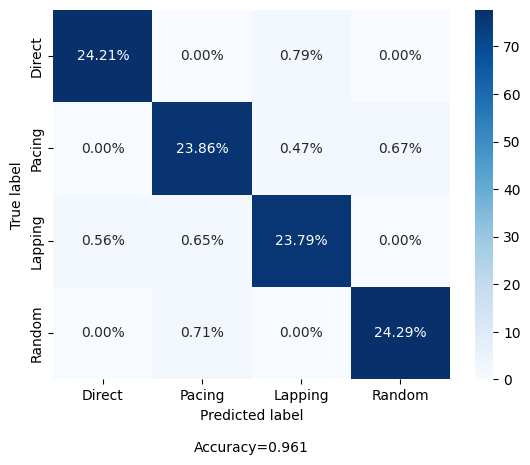

In [17]:
get_graph_matrix(RandomForestClassifier, time_series[2].data, labels)
plt.savefig('./figures/matrix_a.pdf')

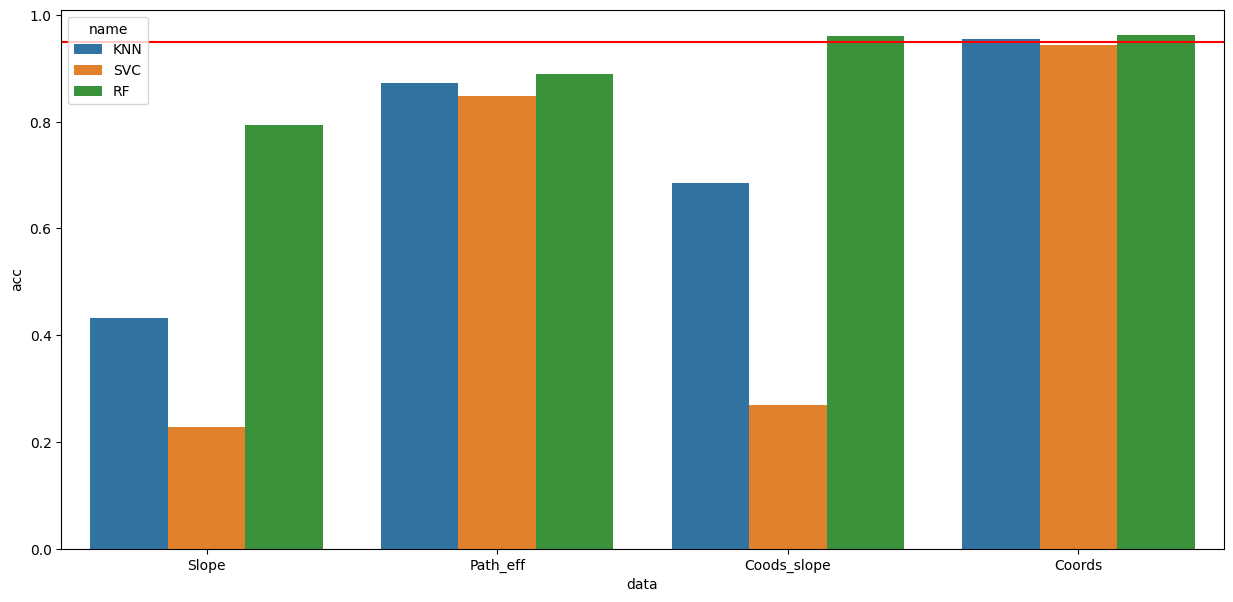

/home/ubuntu/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/.local/lib/python3.8/site-packages/sklearn/metrics/_classification

In [18]:
import seaborn as sns

plt.figure(figsize=[15,7])
bar_plot = sns.barplot(data=bo_params, x='data', y='acc', hue='name')
bar_plot.axhline(0.95, color='red')